In [41]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py

In [42]:
from os import listdir, path
from image_utils import open_image

In [45]:
img_in_dir = "./data/image/sign-language/"
img_out_dir = "../9103-utils/datasets/image/sign-language"

in_dirs = sorted([d for d in listdir(img_in_dir) if path.isdir(path.join(img_in_dir, d))])

def is_image_file(f):
  f_lower = f.lower()
  for e in ["jpg", "jpeg", "png"]:
    if f_lower.endswith(e):
      return True
  return False

for d in in_dirs:
  in_path = path.join(img_in_dir, d)
  fnames = sorted([f for f in listdir(in_path) if is_image_file(f)])
  for i,f in enumerate(fnames):
    img = open_image(path.join(in_path, f)).convert("RGB")
    img.thumbnail([300, 200])
    img.save(path.join(img_out_dir, f"{d}-{('000'+str(i))[-2:]}.jpg"))

In [46]:
import torch

from torch.utils.data import DataLoader
from torchvision.transforms import v2

from nn_utils import SignUtils

In [47]:
train_dataset, test_dataset = SignUtils.train_test_split_cnn(test_ratio=0.2)
len(train_dataset), len(test_dataset)

(83, 20)

torch.Size([64, 3, 224, 224]) torch.Size([64])


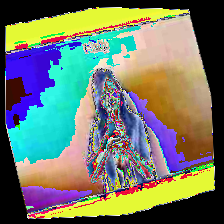

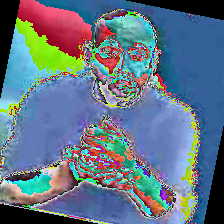

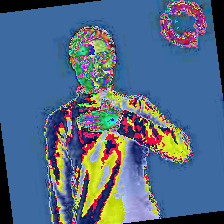

torch.Size([20, 3, 224, 224]) torch.Size([20])


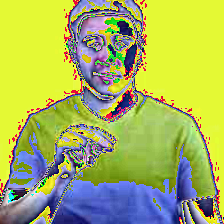

In [48]:
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=64, shuffle=False)

img,label = next(iter(train_dl))
print(img.shape, label.shape)
display(v2.ToPILImage()(img[0]))
display(v2.ToPILImage()(img[1]))
display(v2.ToPILImage()(img[2]))

with torch.no_grad():
  img,label = next(iter(test_dl))
  print(img.shape, label.shape)
  display(v2.ToPILImage()(img[0]))

In [49]:
import numpy as np
import pandas as pd
import os

from PIL import Image

In [50]:
# Set the image path
data_dir = "data/image/sign-language"

In [52]:
# load data
def load_images(data_dir):
  fnames = sorted([f for f in os.listdir(data_dir) if f.endswith("jpg")])

  data = []
  labels = []

  for img_name in fnames:
    label = img_name.split("-")[0]
    # Open the image and grayscale it
    img_path = os.path.join(data_dir, img_name)
    img = Image.open(img_path).convert('L')
    img = img.resize((64, 64))  # 调整到固定大小
    data.append(np.array(img).flatten())  # 展平图像
    labels.append(label)

  return np.array(data), np.array(labels), sorted(list(set(labels)))

In [53]:
# import os
# import numpy as np
# import pandas as pd
# from PIL import Image

# # from data_utils import LFWUtils


In [21]:
# # Set the image path
# data_dir = "data/image"
# categories = ['family', 'hello', 'help', 'house', 'i_love_you', 'no', 'please', 'sorry', 'thankyou', 'yes']

In [54]:
# load_images returns the categories now
X_np, y_np, categories = load_images(data_dir)

# this will have encode the categories into numbers
category2id = {c:i for i,c in enumerate(categories)}

In [62]:
# # Load and preprocess the data
# X_np, y_np = load_images(data_dir, categories)
# X = pd.DataFrame(X_np)
# y = pd.DataFrame(y_np,columns=['label'])
def load_images(data_dir, categories=None):
    fnames = sorted([f for f in os.listdir(data_dir) if f.endswith("jpg")])

    data = []
    labels = []

    for img_name in fnames:
        label = img_name.split("-")[0]
        if categories and label not in categories:
            continue
        # Open the image and grayscale it
        img_path = os.path.join(data_dir, img_name)
        img = Image.open(img_path).convert('L')
        img = img.resize((64, 64))  # Adjust to fixed size
        data.append(np.array(img).flatten())  # Flatten the image
        labels.append(label)

    return np.array(data), np.array(labels)


In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from data_utils import classification_error, display_confusion_matrix

In [64]:
# Data standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality reduction using PCA
pca = PCA(n_components=50)  # Set number of principal components
X_pca = pca.fit_transform(X_scaled)

In [65]:
#  Train-test split, Separate input and output columns for training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_np, test_size=0.2, random_state=42)

# TODO: create a classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

In [66]:
# Train the model using training data and labels
rf_classifier.fit(X_train, y_train)

# Run prediction on train data
train_predictions = rf_classifier.predict(X_train)


Training Accuracy: 100.00%
Training Classification Error: 0.00
Test Accuracy: 9.52%
Confusion Matrix:
 [[0 0 0 1 0 1 0 0 0 0]
 [0 0 1 0 0 2 0 0 0 0]
 [1 2 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 1 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 1]]


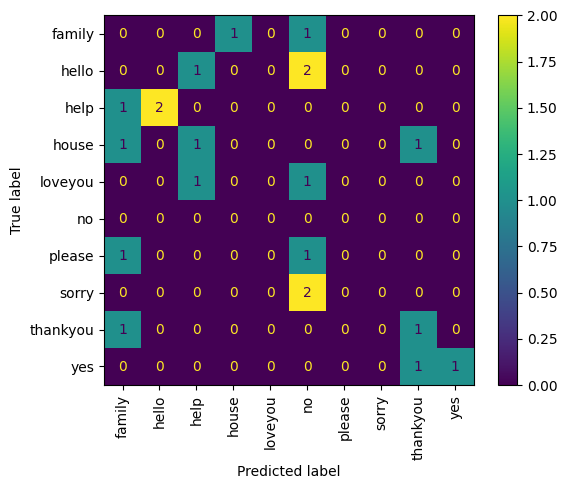

In [67]:
# Validate model with training data
train_accuracy = accuracy_score(y_train, train_predictions)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Classification error for training data
print(f"Training Classification Error: {classification_error(y_train, train_predictions):.2f}")

# Evaluate on the test data
test_predictions = rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion matrix for test data
test_confusion_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:\n", test_confusion_matrix)

display_confusion_matrix(y_test, test_predictions, categories)
